In [1]:
import torch
import torchvision
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [2]:
root = './'
train_data = torchvision.datasets.CIFAR10(root, train=True, transform=None, target_transform=None, download=True)
test_data  = torchvision.datasets.CIFAR10(root, train=False, transform=None, target_transform=None, download=True)
print(len(train_data), len(test_data))

Files already downloaded and verified
Files already downloaded and verified
50000 10000


In [3]:
rgb = lambda x: torch.from_numpy(np.array(x)).view(32*32, 3)[torch.randperm(32*32)[:5], :]
px = torch.cat([rgb(x) for x, y in train_data], dim=0).float()
print(px.size())

torch.Size([250000, 3])


In [4]:
def kmeans(x, ncluster, niter=10):
    N, D = x.size()
    c = x[torch.randperm(N)[:ncluster]] 
    for i in range(niter):
        a = ((x[:, None, :] - c[None, :, :])**2).sum(-1).argmin(1)
        c = torch.stack([x[a==k].mean(0) for k in range(ncluster)])
        nanix = torch.any(torch.isnan(c), dim=1)
        ndead = nanix.sum().item()
        print('done step %d/%d, re-initialized %d dead clusters' % (i+1, niter, ndead))
        c[nanix] = x[torch.randperm(N)[:ndead]]
    return c

ncluster = 512 #make this 512 * 3
with torch.no_grad():
    C = kmeans(px, ncluster, niter=8)

    
C = torch.cat((C,torch.zeros(3).reshape(1,3)),dim=0)
C = torch.cat((C,torch.tensor([255.,255,255]).reshape(1,3)),dim=0)
print(C.size())

done step 1/8, re-initialized 6 dead clusters
done step 2/8, re-initialized 0 dead clusters
done step 3/8, re-initialized 0 dead clusters
done step 4/8, re-initialized 0 dead clusters
done step 5/8, re-initialized 0 dead clusters
done step 6/8, re-initialized 0 dead clusters
done step 7/8, re-initialized 0 dead clusters
done step 8/8, re-initialized 0 dead clusters
torch.Size([514, 3])


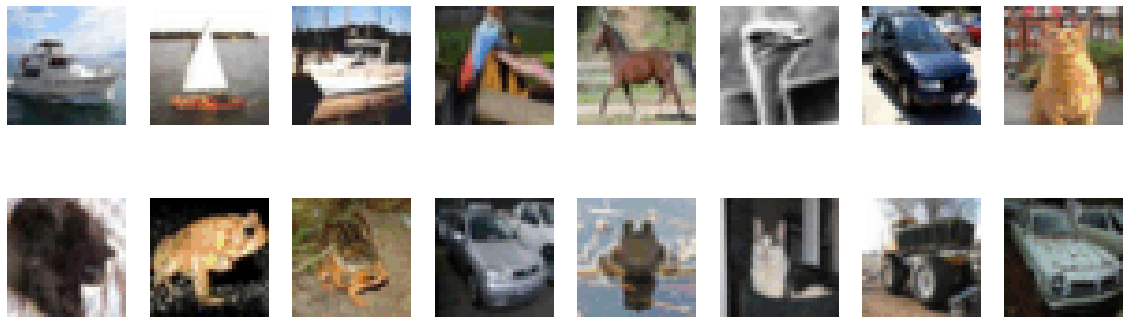

In [5]:
n_samples = 16
ncol = 8
nrow = n_samples // ncol + 1
plt.figure(figsize=(20, 10))
np.random.seed(42)
for i in range(n_samples):
    
    x, y = train_data[np.random.randint(0, len(train_data))]
    xpt = torch.from_numpy(np.array(x)).float().view(32*32, 3)
    ix = ((xpt[:, None, :] - C[None, :, :])**2).sum(-1).argmin(1)
    
    plt.subplot(nrow, ncol, i+1)
    arr = C[ix].view(32, 32, 3).numpy().astype(np.uint8)
    plt.imshow(arr)
    #plt.xkcd()
    plt.axis('off')

In [12]:
cd ..

/content


In [6]:
!rm -rf ICT

In [7]:
!git clone https://github.com/karynaur/ICT.git
%cd ICT

Cloning into 'ICT'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 41 (delta 11), reused 36 (delta 9), pack-reused 0
Unpacking objects: 100% (41/41), done.
/content/ICT


In [16]:
np.pad(torch.tensor([1,2,3]), (0,10),constant_values = 5)

array([1, 2, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [32]:
from torch.utils.data import Dataset
import random
class ImageDataset(Dataset):
    """
    wrap up the pytorch CIFAR-10 dataset into our own, which will convert images into sequences of integers
    """
    
    def __init__(self, pt_dataset, clusters, perm=None):
        self.pt_dataset = pt_dataset
        self.clusters = clusters
        self.perm = torch.arange(32*32) if perm is None else perm
        
        self.vocab_size = clusters.size(0)
        self.pad_idx = clusters.size(0) - 2
        self.mask_idx = clusters.size(0) - 1
        self.block_size = 32*32 
        
    def __len__(self):
        return len(self.pt_dataset)

    def __getitem__(self, idx):
        x, y = self.pt_dataset[idx]
        x = torch.from_numpy(np.array(x)).view(-1, 3) # flatten out all pixels
        x = x[self.perm].float() # reshuffle pixels with any fixed permutation and -> float
        a = ((x[:, None, :] - self.clusters[None, :, :])**2).sum(-1).argmin(1) # cluster assignments
        
        #output = torch.tensor([self.pad_idx for _ in range(self.block_size)])

        
        
        prob=0.8
        mask_indices = torch.randint(self.block_size,(1,int(self.block_size*prob))).reshape(-1)
        no_of_pads = self.block_size - a[mask_indices].shape[0]
        output = torch.tensor(np.pad(a[mask_indices],(0,no_of_pads),constant_values = self.pad_idx))
    
        a[mask_indices] = self.mask_idx
      

   
        return a, output # always just predict the next one in the sequence

train_dataset = ImageDataset(train_data, C)
test_dataset = ImageDataset(test_data, C)
train_dataset[0][0] # one example image flattened out into integers

tensor([513, 397, 513,  ..., 513, 260, 513])

In [35]:
from transformer.model import GPT, GPTConfig, GPT1Config

# we'll do something a bit smaller
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  embd_pdrop=0.0, resid_pdrop=0.0, attn_pdrop=0.0,
                  n_layer=2, n_head=4, n_embd=512, batch_size = 64, mask_token = train_dataset.mask_idx)
model = GPT(mconf)

In [34]:
train_dataset[0][1]

tensor([475, 104,  67,  ..., 512, 512, 512])

In [36]:
from transformer.trainer import Trainer, TrainerConfig


tokens_per_epoch = len(train_data) * train_dataset.block_size
train_epochs = 20 # todo run a bigger model and longer, this is tiny

# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=train_epochs, batch_size=64, learning_rate=2e-3,
                      betas = (0.9, 0.95), weight_decay=0,
                      lr_decay=True, warmup_tokens=tokens_per_epoch, final_tokens=train_epochs*tokens_per_epoch,
                      ckpt_path='cifar10_model.pt',
                      num_workers=2)
trainer = Trainer(model, train_dataset, test_dataset, tconf)
trainer.train()

epoch 1 iter 274: train loss 3.76255. lr 7.040000e-04:  35%|███▌      | 275/782 [06:52<11:28,  1.36s/it]

KeyboardInterrupt: ignored

In [37]:
import torch.nn.functional as F

def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

@torch.no_grad()
def sample(model, x, steps, temperature=1.0, sample=False, top_k=None):
    """
    take a conditioning sequence of indices in x (of shape (b,t)) and predict the next token in
    the sequence, feeding the predictions back into the model each time. Clearly the sampling
    has quadratic complexity unlike an RNN that is only linear, and has a finite context window
    of block_size, unlike an RNN that has an infinite context window.
    """
    block_size = model.get_block_size()
    model.eval()
    ix = torch.tensor([]).to('cuda' if torch.cuda.is_available() else 'cpu')
    for k in range(steps):
        #x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
        logits, _ = model(x)
        # pluck the logits at the final step and scale by temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop probabilities to only the top k options
        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        # apply softmax to convert to probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution or take the most likely
        if sample:
            ix = torch.multinomial(probs, num_samples=1)
        else:
            _, iix = torch.topk(probs, k=1, dim=-1)
        # append to the sequence and continue
        ix = torch.cat((ix,iix),0)
    return ix

In [38]:
x,y = test_data[1]

In [39]:
x = torch.from_numpy(np.array(x)).view(-1, 3) # flatten out all pixels
x = x[train_dataset.perm].float() # reshuffle pixels with any fixed permutation and -> float
a = ((x[:, None, :] - C[None, :, :])**2).sum(-1).argmin(1) # cluster assignments

In [42]:
output = torch.tensor([train_dataset.pad_idx for _ in range(train_dataset.block_size)])
 
prob=0.8
mask_indices = torch.randint(train_dataset.block_size,(1,int(train_dataset.block_size*prob))).reshape(-1)
no_of_pads = train_dataset.block_size - a[mask_indices].shape[0]
output = torch.tensor(np.pad(a[mask_indices],(0,no_of_pads),constant_values = train_dataset.pad_idx))

a[mask_indices] = train_dataset.mask_idx

In [43]:
a = a.to('cuda')

In [47]:
a.shape

torch.Size([1024])

In [50]:
out = sample(model,a.reshape(1,-1),32*32)

RuntimeError: ignored

In [ ]:
for i in out:print(i)

tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([512.], device='cuda:0')
tensor([